# Part 2. Data preparation

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.data import Dataset, Iterator

Our input data are split in three parts. We have three directories train, test and validation. 

In [2]:
glob.glob('./data/chest_xray/*')

['./data/chest_xray/val', './data/chest_xray/test', './data/chest_xray/train']

We'll be working with publicly available data - http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Image files are divided into two folders that indicate if X-Ray represent a **NORMAL** or **PNEUMONIA** example

In [3]:
glob.glob('./data/chest_xray/train/*')

['./data/chest_xray/train/NORMAL', './data/chest_xray/train/PNEUMONIA']

Let's display a few images and try to see differences between two classes

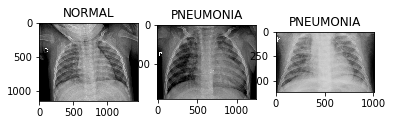

In [4]:
#matplotlib notebook

img_normal = plt.imread('./data/chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('./data/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg')
img_penumonia_virus = plt.imread('./data/chest_xray/train/PNEUMONIA/person1003_virus_1685.jpeg')

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')
plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')
plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

Illustrative Examples of Chest X-Rays in Patients with Pneumonia

- normal chest X-ray (left) depicts clear lungs without any areas of abnormal opacification in the image
- bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows)
- viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

We're going to write a function that maps image path to class:
- 0 = NORMAL
- 1 = PNEUMONIA

In [5]:
def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [6]:
x, y = get_labeled_files('./data/chest_xray/train/')

list(zip(x, y))[:10]

[('./data/chest_xray/train/NORMAL/IM-0545-0001-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0427-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0648-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0660-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0637-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0556-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-1280-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0384-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0452-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0601-0001.jpeg', 0)]

Before we start working with the images need to peform a little of preprocessing, i.e. 
- read the image into an array (3 color channels)
- resize the image to 150px x 150px 
- one hot encode image lables

We are composing the transformations using Tensorflow data pipeline. 

In [7]:
NUM_CLASSES = 2

# This function takes image paths as arguments and reads corresponding images
def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)
    # read the img from file and decode it using tf
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_jpeg(img_file, channels=3, name="decoded_images")
    return img_decoded, one_hot

# This function takes image and resizes it to smaller format (150x150)
def image_resize(images, labels):
    # Be very careful with resizing images like this and make sure to read the doc!
    # Otherwise, bad things can happen - https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35
    resized_image = tf.image.resize_images(images, (150, 150), align_corners=True)
    resized_image_asint = tf.cast(resized_image, tf.int32)
    return resized_image_asint, labels    

In [8]:
# Execution plan is defined here.
# Since it uses lazy evaluation, the images will not be read after calling build_pipeline_plan()
# We need to use iterator defined here in tf context
def build_pipeline_plan(img_paths, labels, batch_size):

    # We build a tensor of image paths and labels
    tr_data = Dataset.from_tensor_slices((img_paths, labels))
    # First step of input pipeline - read images in paths as jpegs
    tr_data_imgs = tr_data.map(input_parser)
    # Apply resize to each image in the pipeline
    tr_data_imgs = tr_data_imgs.map(image_resize)
    # Gives us opportuinty to batch images into small groups
    tr_dataset = tr_data_imgs.batch(batch_size)
    # create TensorFlow Iterator object directly from input pipeline
    iterator = tr_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    return next_element

# Function to execute defined pipeline in Tensorflow session
def process_pipeline(next_element):
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        # get each element of the training dataset until the end is reached
        # in our case only one iteration since we read everything as 1 batch
        # can be multiple iterations if we decrease BATCH_SIZE to eg. 10
        images = []
        labels_hot = []
        while True:
            try:
                elem = sess.run(next_element)
                images = elem[0]
                labels_hot = elem[1]
            except tf.errors.OutOfRangeError:
                print("Finished reading the dataset")
                return images, labels_hot

In [9]:
def load_dataset(path, batch_size):
    tf.reset_default_graph()
    files, labels = get_labeled_files(path)
    p = tf.constant(files, name="train_imgs")
    l = tf.constant(labels, name="train_labels")
    
    next_element = build_pipeline_plan(p, l, batch_size=batch_size)
    imgs, labels = process_pipeline(next_element)
    return imgs, labels

Now, we're going to load load the data (train, test and validation) into separate variables

In [10]:
x_train, y_train = load_dataset("./data/chest_xray/train/", 6000)
x_test, y_test = load_dataset("./data/chest_xray/test/", 6000)
x_val, y_val = load_dataset("./data/chest_xray/val/", 6000)

Finished reading the dataset
Finished reading the dataset
Finished reading the dataset


Let's check the shape of the data structures. All images are 150px x 150px with three color channels.

In [11]:
print(x_train.shape)
print(y_train.shape)

(5216, 150, 150, 3)
(5216, 2)


Target variable is One-hot encoded 

In [12]:
y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

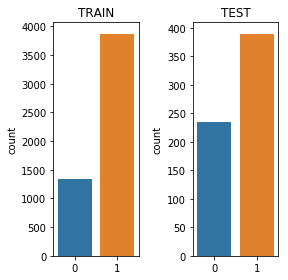

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.subplot(1,3,1)
sns.countplot(np.argmax(y_train, axis=1)).set_title('TRAIN')

plt.subplot(1,3,2)
sns.countplot(np.argmax(y_test, axis=1)).set_title('TEST')

plt.tight_layout()

Our datasets are **imbalanced**. We see more examples with **PNEUMONIA** x-ray images